<h1> Oppurtunity Youth in King County <h1>

For this project we will be looking at data in South King County, Washington at the specific demographic of Opportunity Youth. We hope to find trends that shed light on the systematic difficulties Oppurtunity Youths face as barriers to education and employment.

In [1]:
#import libraries and data
import psycopg2
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
#add this code to import data from the right folders in the parent directory
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

<h1>Creating a map of King County<h1>

In [2]:
#Read in shape file for geo data
gdf = gpd.read_file("src/data/shapefiles/ipums_puma_2010.shp")

In [3]:
#Extract Washington, King County, and South King County
gdf["PUMA"] = gdf["PUMA"].astype(str).astype(int)
washington_map = gdf[(gdf['State']=='Washington')]
greater_king_co_map= gdf[(gdf.PUMA >= 11606) & (gdf.PUMA <= 11616)]
south_king_co_map=gdf[(gdf.PUMA >= 11612) & (gdf.PUMA <= 11615)]

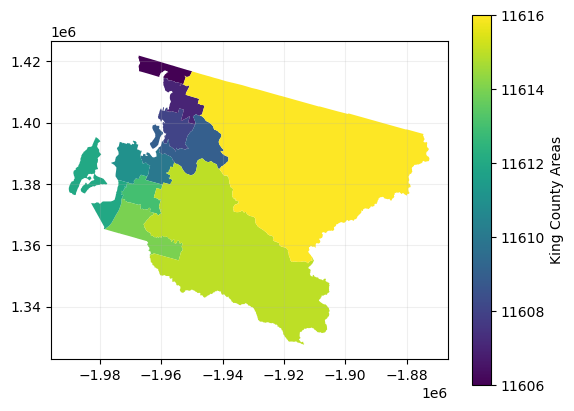

<Figure size 640x480 with 0 Axes>

In [4]:
#Create a cloropeth of pumas in King County
plt.style.use('default')
fig, ax=plt.subplots()
plt.grid(alpha = 0.2)
greater_king_co_map.plot(column='PUMA',ax=ax, legend = True, legend_kwds={'label': "King County Areas"})
plt.show()
plt.savefig('./reports/figures/project_one_map_of_king_county.png', dpi=300, bbox_inches='tight')

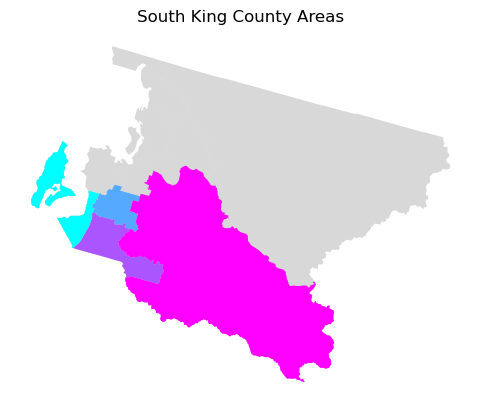

<Figure size 640x480 with 0 Axes>

In [5]:
#Create a cloropeth of pumas in South King County
fig, ax=plt.subplots()
# washington_map.plot(ax=ax, color='grey',alpha = .1, zorder=1)
greater_king_co_map.plot(ax=ax, color='grey',alpha = .3, zorder=1);
south_king_co_map.plot(ax=ax, column = 'PUMA', cmap='cool', zorder= 2)
plt.title('South King County Areas')
plt.axis('off')
plt.show()
plt.savefig('./reports/figures/project_one_map_of_south_king_county.png', dpi=300, bbox_inches='tight')

<h1>Connecting to the Oppurtunity Youth Database<h1>

In [6]:
#connect to database oppurtunity_youth and create cursor
DBNAME = "opportunity_youth"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

In [7]:
#create a list of the table names
cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
tables = []
for table in cursor.fetchall():
    tables.append(table[0])
tables

['pums_2017',
 'puma_names_2010',
 'wa_jobs_2017',
 'wa_geo_xwalk',
 'ct_puma_xwalk']

<h1>Querying the Data<h1>

In [8]:
# Creating a filtered data fram for youth in South King County Washington
# Filter puma_names_2010 to King County in Washington
# Filter pums_2017 for ages between 16 and 25
# Join pums_2017 with filtered puma_names_2010
# SQL query with info for puma, person, age, education, and work
# Column info:
    # PUMA          Public use microdata area code
    # puma_name     County, city, location
    # SERIALNO      Housing unit/GQ person serial number
    # sporder       Which person in housing unit
    # agep          Age
    # sch           school enrollment (1 = has not attended in last 3 months)
    # schl          Education level
    # esr           Employment status

df_weight = pd.read_sql(""" SELECT puma, puma_name, serialno, sporder, agep, sch, schl, esr, pwgtp
                    FROM puma_names_2010 pn
                    JOIN pums_2017 pms
                    USING (puma)
                    WHERE state_name LIKE 'Washington%'
                    AND puma_name LIKE 'King%'
                     AND puma_name LIKE '%South%'
                    AND agep BETWEEN 15.9 AND 25.0
                    ;""", conn)

df_weight

,puma,puma_name,serialno,sporder,agep,sch,schl,esr,pwgtp
0,11606,"King County (Northwest)--Shoreline, Kenmore & ...",2013000003218,01,21.0,3,19,1,14.0
1,11606,"King County (Northwest)--Shoreline, Kenmore & ...",2013000003218,02,21.0,1,16,1,15.0
2,11612,"King County (Far Southwest)--Federal Way, Des ...",2013000007063,02,19.0,2,18,6,30.0
3,11613,King County (Southwest Central)--Kent City ...,2013000008046,02,17.0,2,13,6,36.0
4,11614,King County (Southwest)--Auburn City & Lakelan...,2013000011255,02,17.0,2,12,6,13.0
...,...,...,...,...,...,...,...,...,...
3177,11606,"King County (Northwest)--Shoreline, Kenmore & ...",2017001511157,01,18.0,2,18,6,1.0
3178,11606,"King County (Northwest)--Shoreline, Kenmore & ...",2017001530240,01,18.0,2,19,1,1.0
3179,11613,King County (Southwest Central)--Kent City ...,2017001518359,01,18.0,1,11,6,20.0
3180,11606,"King County (Northwest)--Shoreline, Kenmore & ...",2017001526134,01,18.0,2,18,3,1.0


<h1>Accounting for the weights in the data<h1>

In [9]:
#Function that expands the table from 2878 rows to 68347 using pwgtp to account for the weights
def duplicate_rows(df, countcol):
    for _, row in df.iterrows():
        for i in range(int(row[countcol])-1):
            # Append this row at the end of the DataFrame
            df = df.append(row)

    # Remove countcol (could do a drop too to do that...)
    notcountcols = [x for x in df.columns if x != countcol]
    df = df[notcountcols]
    # optional: sort it by index
    df.sort_index(inplace=True)
    return df

In [ ]:
#**WARNING: THIS CELL MAY TAKE 15 MIN TO RUN**
#Runs the function that expands the table
df_dup = duplicate_rows(df_weight, 'pwgtp')
df_dup = df_dup.reset_index()

<h1>Filtering and Grouping the Data<h1>

In [ ]:
#Code to filter Educational Groups
def school_range (schl):
    if int(schl) < 15: return "No diploma"
    elif int(schl) < 17: return "HS diploma or GED"
    elif int(schl) < 19: return "Some College, no degree"
    elif int(schl) < 25: return "Degree (Associate or higher)"
    else: return "Unknown"
df_dup["School_Level"]= df_dup.schl.apply(school_range)

In [ ]:
#Code to filter Oppurtunity Youth Status
def Y_Status (esr, sch):
    if (int(esr) == 3 or int(esr) == 6) and int(sch) == 1: return "Opportunity Youth"
    elif (int(esr) == 1 or int(esr) == 2 or int(esr) == 4 or int(esr) == 5) and int(sch) <= 15: return "Working without Diploma"
    else: return "Not Opportunity Youth"
df_dup["OY_Status"] = df_dup.apply(lambda x: Y_Status(x["esr"], x["sch"]), axis=1)

In [ ]:
#Code to filter Opportunity Youth Status
def Y_Status (esr, sch):
    if (int(esr) == 3 or int(esr) == 6) and int(sch) == 1: return "Opportunity Youth"
    else: return "Not Opportunity Youth"
df_dup["Is_OY"] = df_dup.apply(lambda x: Y_Status(x["esr"], x["sch"]), axis=1)

In [ ]:
#Code that adds Age_Group and groups ages into bins
df_dup['Age_Group'] = pd.cut(x=df_dup['agep'], bins=[16, 18, 21, 24], labels=['16-18', '19-21', '21-24'])

In [ ]:
#adds Total_Population column that takes the total population of each age group
df_dup["Total_Populations"]=df_dup.groupby("Age_Group")["Age_Group"].transform("count")
df_dup["OY_Status_Counts"]=df_dup.groupby("OY_Status")["OY_Status"].transform("count")

In [ ]:
#Sets up a new dataframe to filter for Oppurtinuty Youth
df_chart = df_dup
df_chart['schl'] = df_chart['schl'].astype(float)

#Creates a dataframe of df_dup that is only Opportunity Youth
oy_chart = df_dup.loc[df_dup["Is_OY"] == "Opportunity Youth"]

#Creates a dataframe of df_dup that is everyone not an Opportunity Youth
noy_chart = df_dup.loc[df_dup["Is_OY"] == "Not Opportunity Youth"]

In [ ]:
#function that adds percentage of total to column
def add_perc_to_column(df, column_n, total):
    df[column_n] = (round(df[column_n]/total*100)).astype(str) + "% : " + (df[column_n]).astype(str)

In [ ]:
#Level of Education by Age
#Group by and count by age group and education level
oy_chart.sort_values(["School_Level"])
totals = oy_chart.groupby(["School_Level"])["Total_Populations"].count()
grouper = oy_chart.groupby(["Age_Group", "School_Level"], as_index=False).count()
total_pop = totals.sum()

<h1>Finding meaning in the data<h1>

In [ ]:
#Creates School Level Pivot
#Cannot find a way to add percentage of population without doing pivot table in excel
sch_piv= pd.pivot_table(data = grouper, index="School_Level", columns="Age_Group", values="Total_Populations",
                       aggfunc = "sum", margins_name="Total", margins=True)
sch_piv

In [ ]:
#Converts to Data Frame and adds percent of population
sch_piv_df = pd.DataFrame(sch_piv.to_records()).set_index('School_Level')
sch_piv_perc_df = sch_piv_df.copy()
[add_perc_to_column(sch_piv_perc_df, c, total_pop) for c in sch_piv_perc_df.columns]
sch_piv_perc_df

In [ ]:
##Opportunity Youth Status by Age
#Group by and count by age group and OY Status
df_dup.sort_values(["Age_Group"])
totals_by_group = df_dup.groupby(["OY_Status"])["Total_Populations"].count()
grouper_oy = df_dup.groupby(["Age_Group", "OY_Status"], as_index=False).count()
total_pop = totals_by_group.sum()

#Creates OY_Status Pivot Table with Totals
#Cannot find a way to add percentage of population without doing pivot table in excel
oy_piv=pd.pivot_table(data=grouper_oy, index="OY_Status", columns="Age_Group", values="Total_Populations",
                      aggfunc = "sum", margins_name="Total", margins=True)
oy_piv

In [ ]:
#Converts to Data Frame and adds percent of population
oy_piv_df = pd.DataFrame(oy_piv.to_records()).set_index('OY_Status')
oy_piv_perc_df = oy_piv_df.copy()
[add_perc_to_column(oy_piv_perc_df, c, total_pop) for c in oy_piv_perc_df.columns]
oy_piv_perc_df

In [ ]:
#Create data fram from csv of 2016 data
#Add Opportunity row
old_oy = pd.read_csv('src/data/csv_files/oy_csv.csv')
old_oy = pd.DataFrame(old_oy)
old_oy = old_oy.set_index('op_youth', drop=True)

#Prepping the the 2017 data for comparison
sch_oy_df=sch_piv_df.append(oy_piv_df[1:2]).reindex(["Opportunity Youth", "No diploma", "HS diploma or GED", "Some College, no degree", "Degree (Associate or higher)"])

<h1>Visuals Comparing 2016 to 2017<h1>

In [ ]:
#A plot to compare the 2016 vs 2017 data
#Note: We can see that our pupulation sample is significantly smaller. This is because we did not include Renton City
#From the data we can see a greater percent of people have finished highschool 2017 but not beyond that
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2, figsize = (12,4))
fig.tight_layout(pad=5)
old_oy2=old_oy[1:]
ax[0].plot(old_oy2.index, old_oy2.values, marker = 'o')
ax[0].set_title('2016 Oppurtunity Youth School Status');
sch_oy2=sch_oy_df[1:]
ax[1].plot(sch_oy2.index, sch_oy2.values, marker = 'o')
ax[1].set_title('2017 Oppurtunity Youth School Status');

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=10)
    plt.legend(['16-18', '19-21', '21-24', 'Total'])

plt.savefig('./reports/figures/project_2016vs2017_oy_education_level.png', dpi=300, bbox_inches='tight')

<h1>Graphs that further demonstrate educational trend in Oppurtunity Youth<h1>

In [ ]:
#Sets up a new dataframe to draw our graphs drom
df_chart = df_dup
df_chart['schl'] = df_chart['schl'].astype(float)
#
#Creates a dataframe of df_dup2 that is only Opportunity Youth
oy_chart = df_dup.loc[df_dup["Is_OY"] == "Opportunity Youth"]
#Creates a dataframe of df_dp2 that is everyone not an Opportunity You
noy_chart = df_dup.loc[df_dup["Is_OY"] == "Not Opportunity Youth"]

In [ ]:
#Builds, labels, titles, the scatter
plt.style.use("default")
fig, ax = plt.subplots(figsize=(10, 6))
ax_scatter = plt.scatter(df_dup.agep, df_dup.schl, alpha=.01, c='green')
plt.title('Level of Education by Age For Youth in South King County', fontsize=16, y=1.05)
plt.xlabel('Age (in years)', fontsize=12)
plt.ylabel('Level of Education', fontsize=12)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'High School Degree',16, 17, 18, 19, 'Associates', 'Bachelors', 22, 23])
plt.grid(alpha=.2)

#best fit line
plt.plot(noy_chart.agep, np.poly1d(np.polyfit(noy_chart.agep, noy_chart.schl, 1))(noy_chart.agep))

#Finding best fit M and B
acx = df_dup.agep
acy = df_dup.schl
acy.to_numpy(dtype="float32")
acx.to_numpy(dtype="float32")
m, b = np.polyfit(acx, acy, 1)

#Saves Graph
plt.savefig('./reports/figures/project_one_scatter_all.png', dpi=300, bbox_inches='tight')

#Prints m, then b, then plots the graph
print(m)
print(b)
plt.show()

In [ ]:
#Builds, labels, titles, the scatter
fig, ax = plt.subplots(figsize=(10, 6))
ax_scatter = plt.scatter(noy_chart.agep, noy_chart.schl, alpha=.01, c='blue')
plt.title('Level of Education by Age For Non Opportunity Youth in South King County', fontsize=16, y=1.05)
plt.xlabel('Age (in years)', fontsize=12)
plt.ylabel('Level of Education', fontsize=12)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'High School Degree',16, 17, 18, 19, 'Associates', 'Bachelors', 22, 23])
plt.grid(alpha=.2)

#best fit line
plt.plot(noy_chart.agep, np.poly1d(np.polyfit(noy_chart.agep, noy_chart.schl, 1))(noy_chart.agep))

#Finding best fit M and B
ncx = noy_chart.agep
ncy = noy_chart.schl
ncy.to_numpy(dtype="float32")
ncx.to_numpy(dtype="float32")
m, b = np.polyfit(ncx, ncy, 1)

#Saves graph
plt.savefig('./reports/figures/project_one_scatter_noy.png', dpi=300, bbox_inches='tight')

#Prints m, then b, then plots the graph
print(m)
print(b)
plt.show()

In [ ]:
#Builds, labels, titles, the scatter
fig, ax = plt.subplots(figsize=(10, 6))
ax_scatter = plt.scatter(oy_chart.agep, oy_chart.schl, alpha=.01, c="coral")
plt.title('Level of Education by Age For Opportunity Youth in South King County', fontsize=16, y=1.05)
plt.xlabel('Age (in years)', fontsize=12)
plt.ylabel('Level of Education', fontsize=12)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'High School Degree',16, 17, 18, 19, 'Associates', 'Bachelors', 22, 23])
plt.grid(alpha=.2)

#Best fit line
plt.plot(oy_chart.agep, np.poly1d(np.polyfit(oy_chart.agep, oy_chart.schl, 1))(oy_chart.agep))
#Finding best fit M and B
ocx = oy_chart.agep
ocy = oy_chart.schl
ocy.to_numpy(dtype="float32")
ocx.to_numpy(dtype="float32")
m, b = np.polyfit(ocx, ocy, 1)

#Saves Graph
plt.savefig('./reports/figures/project_one_scatter_oy.png', dpi=300, bbox_inches='tight')

#Prints m, then b, then plots the graph
print(m)
print(b)
plt.show()

From these graphs we can see the line of best fit through the education levels between Opportunity Youth and None Opportunity Youth. We can conclude that None Opportunity Youth get through their education at about twice the speed as Opportunity Youth